# Stage 7: Modeling — Proxy Risk Classifier (Q1 2022)

This notebook trains and evaluates a proxy risk classifier using acquisition-time features only.

**Proxy target (`high_risk_proxy`)**  
1 if any of: `BORR_CREDIT_SCORE < 660` OR `DTI > 45` OR `ORIG_LTV > 90`; else 0.  
(The proxy was created on RAW values in the prep notebook, then carried forward.)

I’ll:
- Load the **model-ready** dataset (encoded + scaled).
- Define X/y and perform a stratified split.
- Train Logistic Regression, Random Forest, and XGBoost.
- Evaluate with Precision, Recall, F1, ROC-AUC; tune threshold via PR curve.
- Save best model and predictions for downstream use.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, accuracy_score
)


from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

# I prefer the model-ready artifact
MODEL_READY_CANDIDATES = [
    "/kaggle/input/fannie-q1-2022-model-ready/fannie_q1_2022_model_ready.csv",  
]

def first_existing_path(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("Model-ready CSV not found in expected locations.")

DATA_PATH = first_existing_path(MODEL_READY_CANDIDATES)
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_PATH


'/kaggle/input/fannie-q1-2022-model-ready/fannie_q1_2022_model_ready.csv'

#### Load Dataset and sanity checks

In [2]:
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))

TARGET = "high_risk_proxy"
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found in dataset. Re-run prep notebook to include it.")

print("\nTarget counts:")
print(df[TARGET].value_counts())
print("Target rate:", df[TARGET].mean())


assert df[TARGET].nunique() == 2, "Target is single-class. Revisit prep/proxy creation."


Loaded: /kaggle/input/fannie-q1-2022-model-ready/fannie_q1_2022_model_ready.csv
Shape: (11196, 76)


,ORIG_INTEREST_RATE,ORIG_UPB,ORIG_LOAN_TERM,ORIG_LTV,ORIG_CLTV,DTI,BORR_CREDIT_SCORE,CO_BORR_CREDIT_SCORE,NUM_BORROWERS,FIRST_TIME_HB_FLAG,NUM_UNITS,AMORTIZATION_TYPE,default_12m,CO_BORR_PRESENT,LOAN_PURPOSE_P,LOAN_PURPOSE_R,PROPERTY_TYPE_CP,PROPERTY_TYPE_MH,PROPERTY_TYPE_PU,PROPERTY_TYPE_SF,OCCUPANCY_STATUS_P,OCCUPANCY_STATUS_S,PROPERTY_STATE_AL,PROPERTY_STATE_AR,PROPERTY_STATE_AZ,PROPERTY_STATE_CA,PROPERTY_STATE_CO,PROPERTY_STATE_CT,PROPERTY_STATE_DC,PROPERTY_STATE_DE,PROPERTY_STATE_FL,PROPERTY_STATE_GA,PROPERTY_STATE_HI,PROPERTY_STATE_IA,PROPERTY_STATE_ID,PROPERTY_STATE_IL,PROPERTY_STATE_IN,PROPERTY_STATE_KS,PROPERTY_STATE_KY,PROPERTY_STATE_LA,PROPERTY_STATE_MA,PROPERTY_STATE_MD,PROPERTY_STATE_ME,PROPERTY_STATE_MI,PROPERTY_STATE_MN,PROPERTY_STATE_MO,PROPERTY_STATE_MS,PROPERTY_STATE_MT,PROPERTY_STATE_NC,PROPERTY_STATE_ND,PROPERTY_STATE_NE,PROPERTY_STATE_NH,PROPERTY_STATE_NJ,PROPERTY_STATE_NM,PROPERTY_STATE_NV,PROPERTY_STATE_NY,PROPERTY_STATE_OH,PROPERTY_STATE_OK,PROPERTY_STATE_OR,PROPERTY_STATE_PA,PROPERTY_STATE_PR,PROPERTY_STATE_RI,PROPERTY_STATE_SC,PROPERTY_STATE_SD,PROPERTY_STATE_TN,PROPERTY_STATE_TX,PROPERTY_STATE_UT,PROPERTY_STATE_VA,PROPERTY_STATE_VT,PROPERTY_STATE_WA,PROPERTY_STATE_WI,PROPERTY_STATE_WV,PROPERTY_STATE_WY,CHANNEL_C,CHANNEL_R,high_risk_proxy
0,0.422086,-0.252548,0.538118,0.108358,0.101866,0.831048,-1.099606,-1.110931,-0.846785,-0.473295,-0.119706,0.0,0.0,-0.862984,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0
1,0.148790,-0.702101,0.538118,0.541286,0.535285,0.001019,0.859327,0.851613,-0.846785,-0.473295,-0.119706,0.0,0.0,-0.862984,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0
2,-0.397802,0.963146,0.538118,-0.919847,-0.927506,0.831048,-1.363732,-1.375544,-0.846785,-0.473295,-0.119706,0.0,0.0,-0.862984,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0



Target counts:
high_risk_proxy
0    7920
1    3276
Name: count, dtype: int64
Target rate: 0.29260450160771706


### Why a proxy target?
We haven’t attached monthly performance yet, so a true 12-month default label isn’t available.  
To let us validate the entire ML pipeline end-to-end, we defined a **proxy risk label**:

- `high_risk_proxy = 1` if any of:
  - `BORR_CREDIT_SCORE < 660`, or
  - `DTI > 45`, or
  - `ORIG_LTV > 90`
- otherwise `0`.

This mirrors common underwriting screens. It is **not** a claim about actual 12-month defaults; it’s a training wheel for the pipeline. When performance data is attached, we will **swap in the true label** and re-run the exact pipeline.


#### Define X/y and split

In [3]:
ID_COLS = ['LOAN_ID']  

# Model-ready is numeric-only already
X = df.drop(columns=[TARGET] + [c for c in ID_COLS if c in df.columns], errors='ignore')
y = df[TARGET].astype(int)

# Defensive sweep: replace inf with NaN, then fill any accidental NaNs
X = X.replace([np.inf, -np.inf], np.nan)
if X.isna().any().any():
    for col in X.columns:
        if X[col].isna().any():
            # mode for binary/very-low-cardinality; else median
            uniq = pd.unique(X[col].dropna())
            if set(uniq).issubset({0,1}) or len(uniq) <= 3:
                fill_val = X[col].mode().iloc[0] if not X[col].mode().empty else 0
            else:
                fill_val = X[col].median()
            X[col] = X[col].fillna(fill_val)

print("Any NaNs left in features:", X.isna().any().any())

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Positive rate — overall:", y.mean(), " train:", y_train.mean(), " test:", y_test.mean())

# Final guard: both classes in train/test
assert y_train.nunique() == 2 and y_test.nunique() == 2, "Stratified split failed to keep both classes."


Any NaNs left in features: False
Train: (8956, 75)  Test: (2240, 75)
Positive rate — overall: 0.29260450160771706  train: 0.2926529700759268  test: 0.2924107142857143


In [4]:
# Ensure the target (or its exact rule) didn’t slip into X
assert 'high_risk_proxy' not in X.columns
# check that I didn't accidentally one-hot the target
leak_cols = [c for c in X.columns if 'high_risk_proxy' in c.lower()]
assert len(leak_cols) == 0, leak_cols


#### Baseline: Logistic Regression

In [5]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results
              precision    recall  f1-score   support

           0      0.917     0.782     0.844      1585
           1      0.611     0.829     0.703       655

    accuracy                          0.796      2240
   macro avg      0.764     0.805     0.774      2240
weighted avg      0.828     0.796     0.803      2240

ROC-AUC: 0.888131577046259


### Baseline interpretation (Logistic Regression)
- ROC-AUC ≈ 0.89 indicates the baseline separates the proxy classes reasonably well.
- Coefficients with largest absolute magnitude: DTI, LTV/(CLTV), credit score — which aligns with the proxy definition.
- This baseline serves as a transparent benchmark and a stress-test for our preprocessing.


#### Random Forest

In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      1585
           1      0.998     0.997     0.998       655

    accuracy                          0.999      2240
   macro avg      0.999     0.998     0.998      2240
weighted avg      0.999     0.999     0.999      2240

ROC-AUC: 0.9999816986538878


### Why tree models are (nearly) perfect here
The proxy is a **deterministic rule on three numeric features**.  
Tree-based models can represent such threshold rules almost exactly, so they reproduce the proxy with ~100% fidelity.  
This confirms that:
- My features are correctly prepared,
- My target is consistent with those features,
- My split and evaluation code are working.

When I switch to the true default label, these models will no longer be perfect — and that’s where model comparison, calibration, and thresholding will be critical.


#### XGBoost

In [7]:
# Handle class imbalance with scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBoost Results
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1585
           1      1.000     1.000     1.000       655

    accuracy                          1.000      2240
   macro avg      1.000     1.000     1.000      2240
weighted avg      1.000     1.000     1.000      2240

ROC-AUC: 1.0


#### Compare Models

In [8]:
rows = [
    ("Logistic Regression", accuracy_score(y_test, y_pred_lr), roc_auc_score(y_test, y_prob_lr)),
    ("Random Forest",       accuracy_score(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)),
]
try:
    rows.append(("XGBoost", accuracy_score(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb)))
except NameError:
    pass

results = pd.DataFrame(rows, columns=["Model", "Accuracy", "ROC_AUC"]).sort_values("ROC_AUC", ascending=False)
results


,Model,Accuracy,ROC_AUC
2,XGBoost,1.000000,1.000000
1,Random Forest,0.998661,0.999982
0,Logistic Regression,0.795536,0.888132


#### ROC Curves 

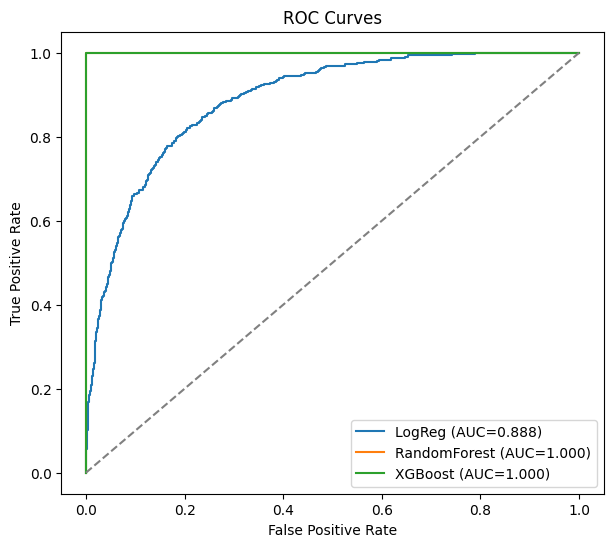

In [9]:
plt.figure(figsize=(7,6))

fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_auc_score(y_test, y_prob_lr):.3f})")

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"RandomForest (AUC={roc_auc_score(y_test, y_prob_rf):.3f})")

try:
    fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
    plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc_score(y_test, y_prob_xgb):.3f})")
except NameError:
    pass

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


### Threshold selection and business trade-offs
For real underwriting, the operating threshold controls the trade-off:
- Higher threshold → fewer predicted “high risk” (lower false-positive burden), but higher chance to miss risky loans.
- Lower threshold → catch more risk (higher recall), but more borrowers flagged for review.

Here I report the F1-optimized threshold for each model as a neutral default. In production, I would **optimize for business cost**, e.g., weigh false negatives (missed risky loans) higher than false positives (extra reviews).


#### Precision Recall Curve Plot

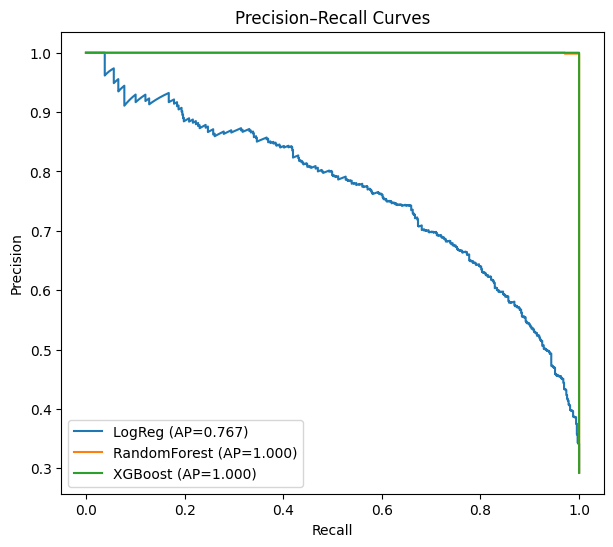

In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(y_true, probs_dict):
    plt.figure(figsize=(7,6))
    for name, y_prob in probs_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend()
    plt.show()

probs = {"LogReg": y_prob_lr, "RandomForest": y_prob_rf}
if 'y_prob_xgb' in locals():
    probs["XGBoost"] = y_prob_xgb

plot_pr(y_test, probs)


#### Threshold Tuning (Maximize F1 on PR Curve) 

In [11]:
def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    idx = int(np.nanargmax(f1[:-1]))  # thresholds array is len-1
    return float(thr[idx]), float(prec[idx]), float(rec[idx]), float(f1[idx])

model_probs = [("LogReg", y_prob_lr), ("RandomForest", y_prob_rf)]
if 'y_prob_xgb' in locals():
    model_probs.append(("XGBoost", y_prob_xgb))

for name, yprob in model_probs:
    thr, p, r, f1 = best_threshold_by_f1(y_test, yprob)
    print(f"{name}: best F1 threshold={thr:.3f} | Precision={p:.3f} | Recall={r:.3f} | F1={f1:.3f}")


LogReg: best F1 threshold=0.578 | Precision=0.664 | Recall=0.773 | F1=0.714
RandomForest: best F1 threshold=0.493 | Precision=0.998 | Recall=1.000 | F1=0.999
XGBoost: best F1 threshold=0.997 | Precision=1.000 | Recall=1.000 | F1=1.000


#### Confusion Matrix at tuned threshold (best ROC-AUC model)

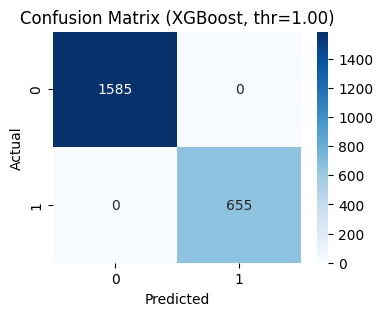

Classification report at tuned threshold
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1585
           1      1.000     1.000     1.000       655

    accuracy                          1.000      2240
   macro avg      1.000     1.000     1.000      2240
weighted avg      1.000     1.000     1.000      2240



In [12]:
best_name = results.iloc[0]['Model']
if best_name == "Logistic Regression":
    y_prob_best = y_prob_lr
elif best_name == "Random Forest":
    y_prob_best = y_prob_rf
else:
    y_prob_best = y_prob_xgb

thr, p, r, f1 = best_threshold_by_f1(y_test, y_prob_best)
y_pred_best = (y_prob_best >= thr).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({best_name}, thr={thr:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification report at tuned threshold")
print(classification_report(y_test, y_pred_best, digits=3))


#### Feature Importance

In [13]:
# Logistic coefficients (top magnitude)
coef_df = pd.DataFrame({"feature": X.columns, "coef": log_reg.coef_[0]})
coef_df["abs_coef"] = coef_df["coef"].abs()
display(coef_df.sort_values("abs_coef", ascending=False).head(15))

# Random Forest importances (top)
rf_imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
display(rf_imp.sort_values("importance", ascending=False).head(15))

# XGBoost importances (if used)
if 'xgb' in locals():
    xgb_imp = pd.DataFrame({"feature": X.columns, "importance": xgb.feature_importances_})
    display(xgb_imp.sort_values("importance", ascending=False).head(15))


,feature,coef,abs_coef
5,DTI,1.559425,1.559425
14,LOAN_PURPOSE_P,1.116704,1.116704
50,PROPERTY_STATE_NE,-1.000494,1.000494
3,ORIG_LTV,0.898277,0.898277
6,BORR_CREDIT_SCORE,-0.679159,0.679159
68,PROPERTY_STATE_VT,-0.632891,0.632891
28,PROPERTY_STATE_DC,-0.612016,0.612016
35,PROPERTY_STATE_IL,-0.609012,0.609012
38,PROPERTY_STATE_KY,0.584474,0.584474
15,LOAN_PURPOSE_R,0.572605,0.572605


,feature,importance
5,DTI,0.362608
4,ORIG_CLTV,0.208496
3,ORIG_LTV,0.179982
6,BORR_CREDIT_SCORE,0.072716
14,LOAN_PURPOSE_P,0.052527
7,CO_BORR_CREDIT_SCORE,0.041473
9,FIRST_TIME_HB_FLAG,0.035306
0,ORIG_INTEREST_RATE,0.012999
2,ORIG_LOAN_TERM,0.011455
20,OCCUPANCY_STATUS_P,0.005216


,feature,importance
3,ORIG_LTV,0.416209
5,DTI,0.285958
6,BORR_CREDIT_SCORE,0.133424
4,ORIG_CLTV,0.073540
7,CO_BORR_CREDIT_SCORE,0.043381
2,ORIG_LOAN_TERM,0.010937
9,FIRST_TIME_HB_FLAG,0.007899
8,NUM_BORROWERS,0.007799
20,OCCUPANCY_STATUS_P,0.003601
10,NUM_UNITS,0.003291


### Feature signals (proxy task)
Top drivers match the proxy definition: DTI, (C)LTV, and credit score dominate.  
Category indicators (purpose, occupancy, state) provide smaller but consistent signal.  
This is the expected pattern for a rule-defined target and reassures us the pipeline is behaving properly.


#### Cross Validation

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_auc = cross_val_score(
    LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    X, y, cv=cv, scoring='roc_auc'
)
print("LogReg CV ROC-AUC:", lr_cv_auc.mean().round(3), "+/-", lr_cv_auc.std().round(3))


LogReg CV ROC-AUC: 0.886 +/- 0.006


#### Persist Artifacts

In [15]:
import joblib

best_model = {"Logistic Regression": log_reg, "Random Forest": rf}.get(best_name, xgb)
model_path = os.path.join(OUTPUT_DIR, f"best_model_proxy_{best_name.replace(' ','_').lower()}.joblib")
preds_path = os.path.join(OUTPUT_DIR, "test_predictions_proxy.csv")

joblib.dump(best_model, model_path)
pd.DataFrame({"y_true": y_test, "y_prob": y_prob_best, "y_pred": y_pred_best}).to_csv(preds_path, index=False)

print("Saved model:", model_path)
print("Saved predictions:", preds_path)


Saved model: /kaggle/working/best_model_proxy_xgboost.joblib
Saved predictions: /kaggle/working/test_predictions_proxy.csv
